In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
from scipy.interpolate import interp1d

In [17]:
spline_kind = 'cubic'
ARRAY_RESOLUTION = 2000

# Speed of light [km/s]
# H0 = 100 * h [km/s/Mpc]
c = 2.99792458e5
EQUATION_OF_STATE_w = -1
SCALE_FACTOR_TODAY  = 1.0

DIMENSIONLESS_h = .70
HUBBLE_CONSTANT = 100*DIMENSIONLESS_h

SEC_TO_YEARS = 3600.0*24.0*365.0
HUBBLE_YEARS = 2.268543540763823e-18*SEC_TO_YEARS

REDSHIFT_START = 1.401
REDSHIFT_END   = .001

MASS_GAP_LOW  = 0.0
MASS_GAP_HIGH = 3.0
NUM_ΔE = 15

Mpc_to_pc = 1.0e6
CONVERT = c/HUBBLE_CONSTANT*Mpc_to_pc/10.0

COV_ROWS = 31

STATS_GRID_SIZE = 1000
M_START = 0
M_END = 1

# Density parameter in ΛCDM:
#  baryonic, dark matter, radiation, dark energy
Ωb = 0.0
Ωm = .3
Ωr = 0.0
ΩΛ = 1.0 - Ωb - Ωm - Ωr

In [3]:
class Brandenberger:
    
    HUBBLE_DIMENSIONLESS_INIT = 17150
    
    τ_INITIAL = 379000.0*HUBBLE_YEARS
    τ_FINAL = 1.0
    τ_TIME  = np.linspace(τ_INITIAL, τ_FINAL, ARRAY_RESOLUTION)
    
    def __init__(self, ΔE, cosmic_time, hubble_param, scale_factor, redshift, shift_param, redshift_lum_dist_spl, luminosity_dist_interp):
        self.ΔE = ΔE
        self.cosmic_time = cosmic_time
        self.hubble_param = hubble_param
        self.scale_factor = scale_factor
        self.redshift = redshift
        self.shift_param = shift_param
        self.redshift_lum_dist_spl = redshift_lum_dist_spl
        self.luminosity_dist_interp = luminosity_dist_interp
        
    def hubble_param_ode(self, h, t):
        return (-3.0/2.0)*h**2.0 + (3.0/2.0)*np.cos(.5*self.ΔE*t)**2.0
    
    def luminosity_distance(self):
        
        luminosity_dist_integrand = lambda x : 1.0/cosmic_t_scale_fac_spline(x)
        
        cosmic_t_scale_fac_spline = interp1d(self.cosmic_time, self.scale_factor, spline_kind)
        
        luminosity_distance = [(1.0 + self.redshift[i])*HUBBLE_YEARS
                               *integrate.quad(
                                   luminosity_dist_integrand,
                                   self.cosmic_time[i],
                                   self.cosmic_time[ARRAY_RESOLUTION - 1]
                               )[0]
                               for i in range(ARRAY_RESOLUTION)]
        
        self.redshift_lum_dist_spl = interp1d(self.redshift, luminosity_distance, spline_kind)
        
        for i in range(ARRAY_RESOLUTION):
            self.luminosity_dist_interp[i] = self.redshift_lum_dist_spl(self.redshift[i])
            
        return self.redshift_lum_dist_spl, self.luminosity_dist_interp
    
    def run_brandenberger(self):
        
        def scale_factor_solve(a, t):
            return a*hubble_spline(t)
            
        def convert_z_to_h(z):
            a = 1.0/(1.0 + z)
            interp_val = scale_fac_hubble_spline(a)
            return interp_val
            
        shift_param_integrand = lambda z : HUBBLE_YEARS/convert_z_to_h(z)

        self.cosmic_time = self.τ_TIME/HUBBLE_YEARS

        cosmic_time_backwards = np.flipud(self.cosmic_time)

        hubble_param_integrated = odeint(self.hubble_param_ode, self.HUBBLE_DIMENSIONLESS_INIT, self.τ_TIME)[...,0]

        self.hubble_param = hubble_param_integrated*HUBBLE_YEARS

        hubble_spline = interp1d(self.cosmic_time, self.hubble_param, spline_kind, fill_value='extrapolate')

        scale_factor_backwards = odeint(scale_factor_solve, SCALE_FACTOR_TODAY, cosmic_time_backwards)[...,0]

        self.scale_factor = np.flipud(scale_factor_backwards)

        self.redshift = 1.0/self.scale_factor - 1.0

        scale_fac_hubble_spline = interp1d(self.scale_factor, self.hubble_param, spline_kind)

        redshift_recombination = self.redshift[0]

        self.shift_param = np.sqrt(Ωm)*integrate.quad(shift_param_integrand, 0, redshift_recombination)[0]

        return self.hubble_param, self.cosmic_time, self.scale_factor, self.redshift, self.shift_param

In [4]:
class ΛCDM:
    
    def __init__(self, redshift, redshift_lum_dist_spl, luminosity_dist_Λ_interp):
        self.redshift = redshift
        self.luminosity_dist_Λ_spl = redshift_lum_dist_spl
        self.luminosity_dist_Λ_interp = luminosity_dist_Λ_interp
        
    def friedmann_equation(self, x):
        H = np.sqrt((Ωb + Ωm)*x**-3.0 + Ωr*x**-4.0 + ΩΛ*x**(-3.0*(1.0 + EQUATION_OF_STATE_w)))
        return H
    
    def luminosity_distance_ΛCDM(self):
        luminosity_dist_integrand = lambda x : 1.0/(x**2.0 * self.friedmann_equation(x))
        
        luminosity_distance = [(1.0 + self.redshift[i])*integrate.quad(luminosity_dist_integrand, 1.0/(1.0 + self.redshift[i]), 1)[0] for i in range(ARRAY_RESOLUTION)]
        
        self.redshift_lum_dist_spl = interp1d(self.redshift, luminosity_distance, spline_kind)
        
        return self.redshift_lum_dist_spl
    
    def redshift_ΛCDM(self):
        self.redshift = np.linspace(REDSHIFT_START, REDSHIFT_END, num=ARRAY_RESOLUTION, endpoint=True)
        
        return self.redshift
    

In [18]:
ΔE = np.linspace(MASS_GAP_LOW, MASS_GAP_HIGH, NUM_ΔE, endpoint=True)

ΔE_inst = np.ndarray((NUM_ΔE,), dtype=np.object)

instantiate_spl_x = [1, 2, 3, 4]
instantiate_spl_y = [1, 2, 3, 4]

instantiate_spl = interp1d(instantiate_spl_x, instantiate_spl_y, spline_kind)

for i in range(NUM_ΔE):
    print('ΔE[%s] = %.3f' % (i, ΔE[i]))
    
    ΔE_inst[i] = Brandenberger(
        ΔE[i], 
        cosmic_time=np.zeros(ARRAY_RESOLUTION),
        hubble_param=np.zeros(ARRAY_RESOLUTION),
        scale_factor=np.zeros(ARRAY_RESOLUTION),
        redshift=np.zeros(ARRAY_RESOLUTION),
        shift_param=1.0,
        redshift_lum_dist_spl=instantiate_spl,
        luminosity_dist_interp=np.zeros(ARRAY_RESOLUTION)
    )
    
    ΔE_inst[i].run_brandenberger()
    
    %time ΔE_inst[i].luminosity_distance()
    
    print('\n')
    
print(' -- All ΔE luminosity distances completed -- ')

ΔE[0] = 0.000
Wall time: 3.98 s


ΔE[1] = 0.214
Wall time: 3.16 s


ΔE[2] = 0.429
Wall time: 3.25 s


ΔE[3] = 0.643
Wall time: 3.69 s


ΔE[4] = 0.857
Wall time: 3.24 s


ΔE[5] = 1.071
Wall time: 3.21 s


ΔE[6] = 1.286
Wall time: 3.28 s


ΔE[7] = 1.500
Wall time: 3.19 s


ΔE[8] = 1.714
Wall time: 3.17 s


ΔE[9] = 1.929
Wall time: 3.17 s


ΔE[10] = 2.143
Wall time: 3.18 s


ΔE[11] = 2.357
Wall time: 3.22 s


ΔE[12] = 2.571
Wall time: 3.12 s


ΔE[13] = 2.786
Wall time: 3.26 s


ΔE[14] = 3.000
Wall time: 3.17 s


 -- All ΔE luminosity distances completed -- 


In [6]:
CDMinst = ΛCDM(
    redshift=np.zeros(ARRAY_RESOLUTION),
    redshift_lum_dist_spl=instantiate_spl,
    luminosity_dist_Λ_interp=np.zeros(ARRAY_RESOLUTION)
)

CDMinst.redshift_ΛCDM()
CDMinst.luminosity_distance_ΛCDM()

print(' -- ΛCDM completed -- ')

 -- ΛCDM completed -- 


In [7]:
sn_data_init = []
n_rows  = 0

with open('jla_likelihood_v6\data\jla_mub.txt', 'r') as reader:
    for line in reader:
        sn_data_init.append(line)
        n_rows += 1
        
reader.close()
col_num = 2
data_shape = (n_rows - 1, col_num)
sn_data = np.zeros(data_shape)
zb_mod = np.zeros(n_rows - 1)
μb_mod = np.zeros(n_rows - 1)

for i in range(1, n_rows):
    split = sn_data_init[i].split()
    for j in range(col_num):
        sn_data[i - 1][j] = split[j]
        zb_mod[i - 1] = split[0]
        μb_mod[i - 1] = split[1]
        
print(' -- Binned data table loaded -- ')

 -- Binned data table loaded -- 


In [ ]:
def resize(d_array):
    return np.concatenate(
        (np.zeros(COV_ROWS - len(d_array)), d_array),
        axis=None
    )

C = np.array([
              resize([21282, -10840, 1918, 451, 946, 614, 785, 686, 581, 233, 881, 133, 475, 295, 277, 282, 412, 293, 337, 278, 219, 297, 156, 235, 133, 179, -25, -106,   0, 137, 168]),
              resize([28155,  -2217, 1702,  74, 322, 380, 273, 424, 487, 266, 303, 406, 468, 447, 398, 464, 403, 455, 468, 417, 444, 351, 399,  83, 167, -86,  15,   -2,  76, 243]),
              resize([ 6162,  -1593, 1463, 419, 715, 580, 664, 465, 613, 268, 570, 376, 405, 352, 456, 340, 412, 355, 317, 341, 242, 289, 119, 152, -69, -33, -44,   37, 209]),
              resize([ 5235,   -722,  776, 588, 591, 583, 403, 651, 212, 555, 353, 355, 323, 442, 319, 372, 337, 288, 343, 210, 272,  92, 167, -48, -29, -21,  50,  229]),
              resize([ 7303,   -508, 1026, 514, 596, 315, 621, 247, 493, 320, 375, 290, 383, 286, 350, 300, 269, 313, 198, 251,  99, 126,  18,  46,  13,  10, 203]),
              resize([ 3150,   -249,  800, 431, 358, 414, 173, 514, 231, 248, 221, 293, 187, 245, 198, 175, 231, 126, 210, 103, 170,  51,  66,  -8, -51, 308]),
              resize([ 3729,    -88,  730, 321, 592, 188, 546, 316, 342, 290, 389, 267, 341, 285, 252, 301, 189, 242, 122, 159,  35,  72,  30,  28, 255]),
              resize([ 3222,   -143,  568, 421, 203, 491, 257, 280, 240, 301, 221, 275, 227, 210, 249, 148, 220, 123, 160,  43,  69,  27,   7, 253]),
              resize([ 3225,   -508,  774, 156, 502, 273, 323, 276, 370, 260, 316, 273, 231, 273, 171, 226, 111, 154,   0,  29,  19,  23, 206]),
              resize([ 5646,  -1735,  691, 295, 362, 316, 305, 370, 280, 346, 313, 276, 310, 217, 274, 131, 175,  38, 118,  78,  48, 303]),
              resize([ 8630,  -1642,  944, 152, 253, 184, 274, 202, 254, 233, 196, 237, 156, 207,  27, 115, -32,   7, -15,   0, 176]),
              resize([ 3855,   -754,  502, 225, 278, 294, 274, 285, 253, 239, 255, 173, 229, 181, 177,  93, 124, 132, 108, 227]),
              resize([ 4340,   -634,  660, 240, 411, 256, 326, 276, 235, 290, 184, 256, 135, 222,  90, 152,  67,  17, 318]),
              resize([ 2986,   -514,  479, 340, 363, 377, 362, 315, 343, 265, 311, 144, 198,  17,  62,  86, 147, 226]),
              resize([ 3592,   -134,  606, 333, 422, 374, 333, 349, 267, 300, 157, 184,   9,  71,  85, 136, 202]),
              resize([ 1401,     22,  431, 343, 349, 302, 322, 245, 284, 171, 186,  70,  70,  93, 142, 202]),
              resize([ 1491,    141,  506, 386, 356, 394, 278, 306, 188, 212,  79,  71, 106, 145, 240]),
              resize([ 1203,    200,  435, 331, 379, 281, 311, 184, 209,  49,  51, 110, 197, 181]),
              resize([ 1032,    258,  408, 398, 305, 330, 197, 223,  78,  79, 113, 174, 225]),
              resize([ 1086,    232,  453, 298, 328, 120, 189, -48,  22,  42, 142, 204]),
              resize([ 1006,    151,  329, 282, 169, 195,  58,  80,  95, 192, 188]),
              resize([ 1541,    124,  400, 199, 261, 150, 166, 202, 251, 251]),
              resize([ 1127,     72,  227, 222,  93, 118,  93, 171, 161]),
              resize([ 1723,   -105,  406,  -3, 180, 190, 198, 247]),
              resize([ 1550,    144,  946, 502, 647, 437, 215]),
              resize([ 1292,    187,  524, 393, 387, 284]),
              resize([ 3941,    587, 1657, 641, 346]),
              resize([ 2980,    360, 1124, 305]),
              resize([ 4465,  -1891,  713]),
              resize([23902,  -1826]),
              resize([19169])
            ])

C = 1.0e-6*C

print(' -- Resizing done -- ')

for i in range(1, COV_ROWS):
    if i == 1:
        C[1][0] = C[0][1]
    else:
        for j in range(i):
            C[i][j] = C[j][i]
            
C_inverse = np.linalg.inv(C)

err = [np.sqrt(C[i][i]) for i in range(COV_ROWS)]

print(' -- Symmetrizing / transposing C matrix -- ')

ΔE = 0.000 || M = 0.00000  || χ2 = 131.40037
ΔE = 0.214 || M = 0.00000  || χ2 = 126.60541
ΔE = 0.429 || M = 0.00000  || χ2 = 113.01494
ΔE = 0.643 || M = 0.00000  || χ2 = 92.95931
ΔE = 0.857 || M = 0.00000  || χ2 = 70.12698
ΔE = 1.071 || M = 0.00000  || χ2 = 49.25999
ΔE = 1.286 || M = 0.00000  || χ2 = 35.74763
ΔE = 1.500 || M = -0.01502 || χ2 = 34.39247
ΔE = 1.714 || M = -0.06206 || χ2 = 39.68830
ΔE = 1.929 || M = -0.11211 || χ2 = 49.88235
ΔE = 2.143 || M = -0.16316 || χ2 = 65.49414
ΔE = 2.357 || M = -0.21522 || χ2 = 86.38580
ΔE = 2.571 || M = -0.26627 || χ2 = 111.57243
ΔE = 2.786 || M = -0.31532 || χ2 = 139.14524
ΔE = 3.000 || M = -0.36036 || χ2 = 166.36390
ΛCDM       || M = 0.00000  || χ2 = 33.65355


χ2: [131.40037342 126.60541117 113.01494376  92.95930904  70.12697881
  49.2599852   35.74762726  34.3924711   39.68830261  49.88235155
  65.4941418   86.3858033  111.57243468 139.14524138 166.36389924
  33.65354799]


Min of χ2: 33.65355
Min of ΔE χ2: 34.39247
This corresponds to ΛCDM, 

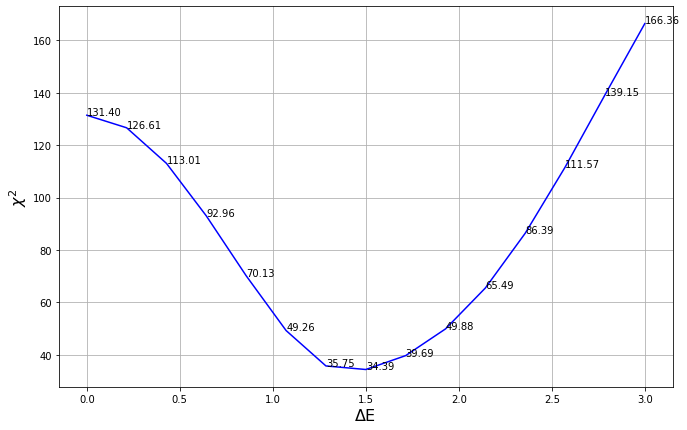

In [21]:
def minimize_m(zb_mod, μb_matrix, m_matrix, lum_dist_matrix, C_inverse):
    m_matrix = m_matrix * 0
    for i in range(STATS_GRID_SIZE):
        m_matrix += m_min_low[i]
        
        r_matrix = μb_matrix - m_matrix - lum_dist_matrix
        r_dagger_matrix = np.transpose(r_matrix)
        χ_low[i] = np.matmul(r_dagger_matrix, np.matmul(C_inverse, r_matrix))
        
        m_matrix += m_min_high[i]
        
        r_matrix = μb_matrix - m_matrix - lum_dist_matrix
        r_dagger_matrix = np.transpose(r_matrix)
        χ_high[i] = np.matmul(r_dagger_matrix, np.matmul(C_inverse, r_matrix))
        
    χ_min_low  = min(χ_low)
    χ_min_high = min(χ_high)
    
    if χ_min_low < χ_min_high:
        m_index = np.argmin(χ_low)
        return χ_min_low, m_min_low[m_index]
    elif χ_min_high < χ_min_low:
        m_index = np.argmin(χ_high)
        return χ_min_high, m_min_high[m_index]
    else:
        m_index = np.argmin(χ_low)
        return χ_min_low, m_min_low[m_index]


def χsq_calc(zb_mod, μb_mod, lum_dist_theory_spl, C_inverse):
    
    for i in range(COV_ROWS):
        lum_dist_matrix[i] = 5.0*np.log(lum_dist_theory_spl(zb_mod[i])*CONVERT)/np.log(10.0)
        μb_matrix[i] = μb_mod[i]
    
    χ2, m_min = minimize_m(zb_mod, μb_matrix, m_matrix, lum_dist_matrix, C_inverse)
    
    return χ2, m_min

def get_model(index, χsq):
    if index < NUM_ΔE:
        return 'ΔE min = %.2f at index %s' % (ΔE[index_min], index)
    elif index == NUM_ΔE:
        return 'ΛCDM, Ωm = %.2f with χ2 = %.2f' % (Ωm, χsq[index])
    elif index == (NUM_ΔE + 1):
        return 'an empty universe'
    elif index == (NUM_ΔE + 2):
        return 'a vacuum dominated universe'


lum_dist_matrix = np.zeros((COV_ROWS, 1))
μb_matrix = np.zeros((COV_ROWS, 1))

m_min_low = np.linspace(M_START, -M_END, num=STATS_GRID_SIZE, endpoint=True)
m_min_high = np.linspace(M_START, M_END, num=STATS_GRID_SIZE, endpoint=True)

χ_low = np.zeros(STATS_GRID_SIZE)
χ_high = np.zeros(STATS_GRID_SIZE)
χsq = np.zeros(NUM_ΔE + 1)
m_min = np.zeros(NUM_ΔE + 1)

m_matrix = np.zeros((COV_ROWS, 1))

for i in range(NUM_ΔE + 1):
    if i < NUM_ΔE:
        χsq[i], m_min[i] = χsq_calc(zb_mod, μb_mod, ΔE_inst[i].redshift_lum_dist_spl, C_inverse)
        if i <= 6:
            print('ΔE = %.3f || M = %.5f  || χ2 = %.5f' % (ΔE[i], m_min[i], χsq[i]))
        else:
            print('ΔE = %.3f || M = %.5f || χ2 = %.5f' % (ΔE[i], m_min[i], χsq[i]))
    elif i == NUM_ΔE:
        χsq[i], m_min[i] = χsq_calc(zb_mod, μb_mod, CDMinst.redshift_lum_dist_spl, C_inverse)
        print('ΛCDM       || M = %.5f  || χ2 = %.5f' % (m_min[i], χsq[i]))     
        
print('\n')
print('χ2:', χsq)
print('\n')
print('Min of χ2: %.5f' % min(χsq))
print('Min of ΔE χ2: %.5f' % min(χsq[0:NUM_ΔE]))
index_min = np.argmin(χsq[:])
index_min_Bb = np.argmin(χsq[0:len(ΔE)])
print('This corresponds to', get_model(index_min, χsq))
print('\n')

plt.figure(figsize = (11, 7))
plt.plot(ΔE, χsq[0:NUM_ΔE], 'b')
for i, j in zip(ΔE, χsq[:]): plt.annotate('%.2f' % j, xy = (i, j), textcoords = 'data')
plt.xlabel('ΔE', fontsize = 16)
plt.ylabel('$χ^2$', fontsize = 16)
plt.grid()
plt.show()